# Clustering & outlier detection code for austenitic stainless-steels data

This code will explore outlier identification and clustering techniques for the Austenitic Stainless Steel data.

In [2]:
# import libraries
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [6]:
# Import data
df_tensile_numeric = pd.read_csv('AusSS_all_data_cleaned.csv')

In [7]:
# Run this to see all rows, columns of output
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

## Get unique data

In [63]:
# Set attributes included
df_tensile_outliers_ID = df_tensile_numeric.iloc[:, 0:25]

# Get unique values only

df_tensile_outliers_ID = df_tensile_outliers_ID.drop_duplicates(keep='first')
df_tensile_outliers_ID = df_tensile_outliers_ID.reset_index(drop=True)

df_tensile_outliers = df_tensile_outliers_ID.iloc[:, 1:25]

df_tensile_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 24 columns):
Fe         129 non-null float64
C          129 non-null float64
Cr         129 non-null float64
Mn         129 non-null float64
Si         125 non-null float64
Ni         129 non-null float64
Co         61 non-null float64
Mo         102 non-null float64
W          28 non-null float64
Nb         87 non-null float64
Al         101 non-null float64
P          125 non-null float64
Cu         103 non-null float64
Ta         29 non-null float64
V          37 non-null float64
B          56 non-null float64
N          107 non-null float64
O          32 non-null float64
S          129 non-null float64
Y          7 non-null float64
Homo       129 non-null float64
Normal     93 non-null float64
Temper1    9 non-null float64
AGS No.    73 non-null float64
dtypes: float64(24)
memory usage: 24.3 KB


In [64]:
# Save a copy of the dataframe with missing values
df_tensile_outliers_mv = df_tensile_outliers.copy(deep=True)
df_tensile_outliers_ID_mv = df_tensile_outliers_ID.copy(deep=True)

## Examine distributions of attributes, with missing values

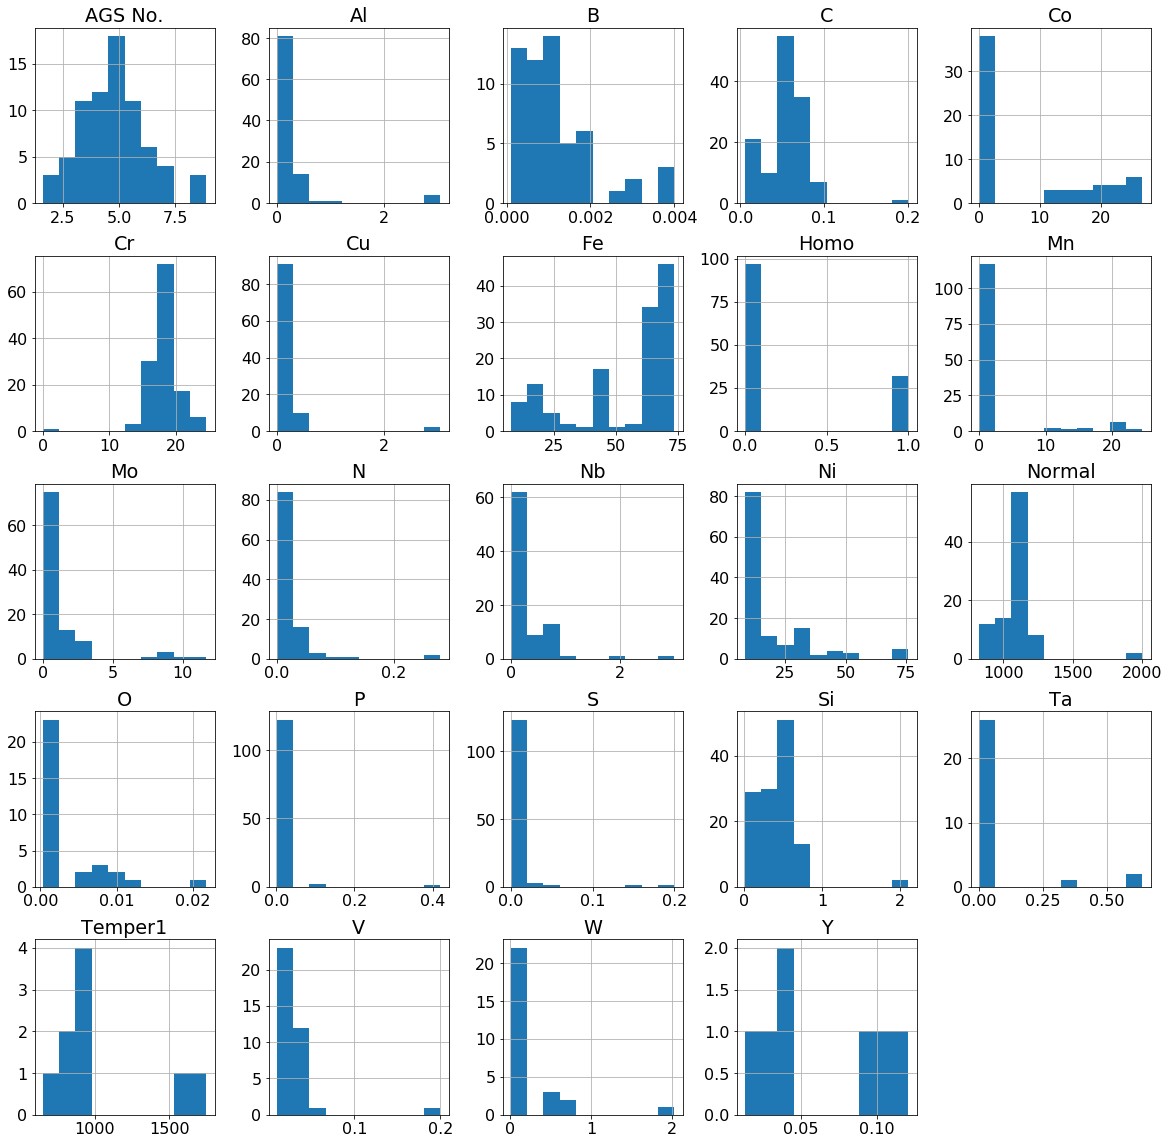

In [67]:
font = {'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
df_tensile_outliers_mv.iloc[:, 0:24].hist(figsize = (20,20));

In [66]:
df_tensile_outliers_mv.describe()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Y,Homo,Normal,Temper1,AGS No.
count,129.000000,129.000000,129.000000,129.000000,125.000000,129.000000,61.000000,102.000000,28.000000,87.000000,101.000000,125.000000,103.000000,29.000000,37.000000,56.000000,107.000000,32.000000,129.000000,7.000000,129.000000,93.000000,9.000000,73.000000
mean,53.267792,0.054499,18.168209,2.668473,0.431784,20.141865,7.673738,1.119294,0.201193,0.252414,0.227465,0.020703,0.173583,0.060724,0.024514,0.001157,0.024248,0.003388,0.010756,0.062186,0.248062,1096.279570,1023.333333,4.760274
std,20.795726,0.026246,2.467215,4.998337,0.314964,15.468657,10.032588,2.265239,0.439868,0.463745,0.593919,0.039371,0.414658,0.172884,0.032478,0.000971,0.040116,0.004805,0.022044,0.043403,0.433572,162.006667,383.277641,1.533310
min,7.480000,0.005100,0.010000,0.010000,0.010000,8.420000,0.010000,0.001000,0.008000,0.001000,0.003000,0.001000,0.003000,0.001000,0.010000,0.000100,0.000360,0.000300,0.000100,0.012800,0.000000,825.000000,650.000000,1.600000
25%,43.568400,0.049900,17.110000,0.600000,0.260000,10.700000,0.220000,0.030000,0.010000,0.010000,0.011000,0.005000,0.020000,0.001000,0.010000,0.000500,0.006550,0.000500,0.002000,0.030000,0.000000,1050.000000,800.000000,3.700000
50%,65.698500,0.060000,18.170000,1.460000,0.460000,12.590000,0.330000,0.105000,0.010000,0.020000,0.023000,0.018000,0.090000,0.001000,0.010000,0.001000,0.017900,0.001100,0.007000,0.041700,0.000000,1100.000000,871.000000,4.800000
75%,68.396400,0.070000,18.800000,1.700000,0.580000,25.890000,16.950000,2.065000,0.042550,0.470000,0.160000,0.025000,0.165000,0.010000,0.032000,0.001375,0.027900,0.006000,0.013000,0.100100,0.000000,1140.000000,954.000000,5.400000
max,73.480000,0.200500,24.600000,24.470000,2.110000,75.871000,26.820000,11.680000,2.030000,2.990000,3.060000,0.420000,3.050000,0.640000,0.200000,0.004000,0.280000,0.021800,0.200000,0.120600,1.000000,2000.000000,1750.000000,8.900000


## Fill in missing values, reduce dataset to unique values

In [12]:
# fill in Homogenization column (0/1) with 0
df_tensile_outliers_ID['Homo'].fillna(value = 0, inplace = True)
df_tensile_outliers['Homo'].fillna(value = 0, inplace = True)

In [13]:
# fill attributes used in outlier analysis with mean of column values; fill rest with 0
df_tensile_outliers_ID.fillna(value = df_tensile_outliers_ID.mean(), inplace = True)
df_tensile_outliers.fillna(value = df_tensile_outliers.mean(), inplace = True)

In [68]:
# range of data with missing values filled in
df_tensile_outliers_ID.describe()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Y,Homo,Normal,Temper1,AGS No.
count,129.000000,129.000000,129.000000,129.000000,125.000000,129.000000,61.000000,102.000000,28.000000,87.000000,101.000000,125.000000,103.000000,29.000000,37.000000,56.000000,107.000000,32.000000,129.000000,7.000000,129.000000,93.000000,9.000000,73.000000
mean,53.267792,0.054499,18.168209,2.668473,0.431784,20.141865,7.673738,1.119294,0.201193,0.252414,0.227465,0.020703,0.173583,0.060724,0.024514,0.001157,0.024248,0.003388,0.010756,0.062186,0.248062,1096.279570,1023.333333,4.760274
std,20.795726,0.026246,2.467215,4.998337,0.314964,15.468657,10.032588,2.265239,0.439868,0.463745,0.593919,0.039371,0.414658,0.172884,0.032478,0.000971,0.040116,0.004805,0.022044,0.043403,0.433572,162.006667,383.277641,1.533310
min,7.480000,0.005100,0.010000,0.010000,0.010000,8.420000,0.010000,0.001000,0.008000,0.001000,0.003000,0.001000,0.003000,0.001000,0.010000,0.000100,0.000360,0.000300,0.000100,0.012800,0.000000,825.000000,650.000000,1.600000
25%,43.568400,0.049900,17.110000,0.600000,0.260000,10.700000,0.220000,0.030000,0.010000,0.010000,0.011000,0.005000,0.020000,0.001000,0.010000,0.000500,0.006550,0.000500,0.002000,0.030000,0.000000,1050.000000,800.000000,3.700000
50%,65.698500,0.060000,18.170000,1.460000,0.460000,12.590000,0.330000,0.105000,0.010000,0.020000,0.023000,0.018000,0.090000,0.001000,0.010000,0.001000,0.017900,0.001100,0.007000,0.041700,0.000000,1100.000000,871.000000,4.800000
75%,68.396400,0.070000,18.800000,1.700000,0.580000,25.890000,16.950000,2.065000,0.042550,0.470000,0.160000,0.025000,0.165000,0.010000,0.032000,0.001375,0.027900,0.006000,0.013000,0.100100,0.000000,1140.000000,954.000000,5.400000
max,73.480000,0.200500,24.600000,24.470000,2.110000,75.871000,26.820000,11.680000,2.030000,2.990000,3.060000,0.420000,3.050000,0.640000,0.200000,0.004000,0.280000,0.021800,0.200000,0.120600,1.000000,2000.000000,1750.000000,8.900000


## Scale data, apply PCA and kMeans

In [53]:
# Scale data
df_scale = StandardScaler().fit_transform(df_tensile_outliers)

In [54]:
# Apply PCA

# Make an instance of the Model
pca_model = PCA(n_components = 0.90)

# fit PCA on training set
data_PCA = pca_model.fit_transform(df_scale)

df_PCA = pd.DataFrame(data = data_PCA)


pca_model.explained_variance_ratio_

array([0.16477615, 0.10716776, 0.0815904 , 0.07463316, 0.06605534,
       0.0618655 , 0.05551733, 0.05079724, 0.04283614, 0.03915564,
       0.03610812, 0.03384037, 0.03138918, 0.02820842, 0.02729756])

In [55]:
pca_model.n_components_

15

In [56]:
(pca_model.explained_variance_ratio_[0]*100).round(1)

16.5

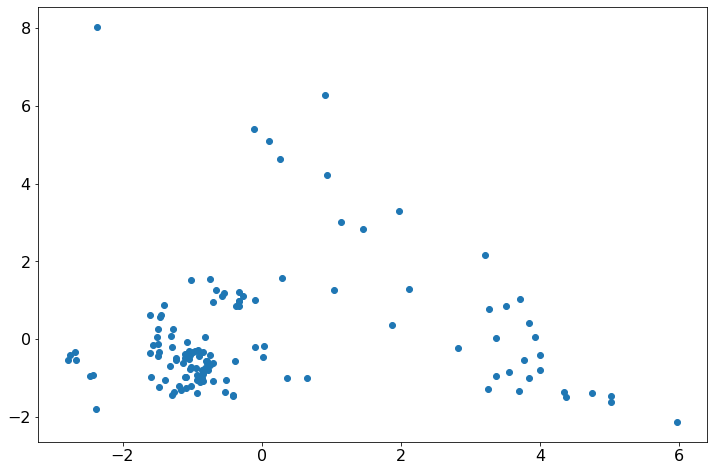

In [57]:
plt.figure(figsize = (12,8))
plt.scatter(df_PCA[0], df_PCA[1]);

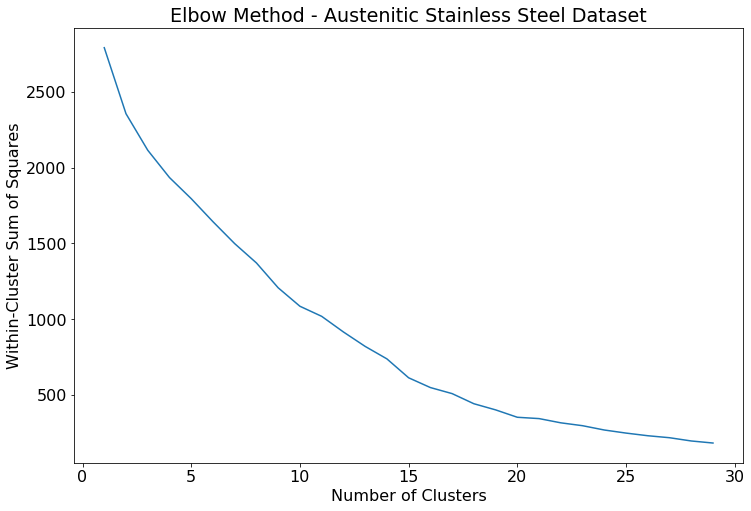

In [69]:
# Elbow method to determine optimum number of clusters
plt.figure(figsize = (12,8))
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_PCA) # df_PCA
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 30), wcss)
plt.title('Elbow Method - Austenitic Stainless Steel Dataset')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

In [24]:
# Silhouette Score to determine optimum number of clusters

Automatically created module for IPython interactive environment
For n_clusters = 7 The average silhouette_score is : 0.4156535726206059
For n_clusters = 8 The average silhouette_score is : 0.4262017435824855
For n_clusters = 9 The average silhouette_score is : 0.3514990269633013
For n_clusters = 10 The average silhouette_score is : 0.3558402403983437
For n_clusters = 11 The average silhouette_score is : 0.3506469439684364
For n_clusters = 12 The average silhouette_score is : 0.3785095829405317
For n_clusters = 13 The average silhouette_score is : 0.36192623533430507
For n_clusters = 14 The average silhouette_score is : 0.34296249208635665
For n_clusters = 15 The average silhouette_score is : 0.42723225756129674
For n_clusters = 16 The average silhouette_score is : 0.41228822422416483
For n_clusters = 17 The average silhouette_score is : 0.25865184885999426
For n_clusters = 18 The average silhouette_score is : 0.3910251326914444


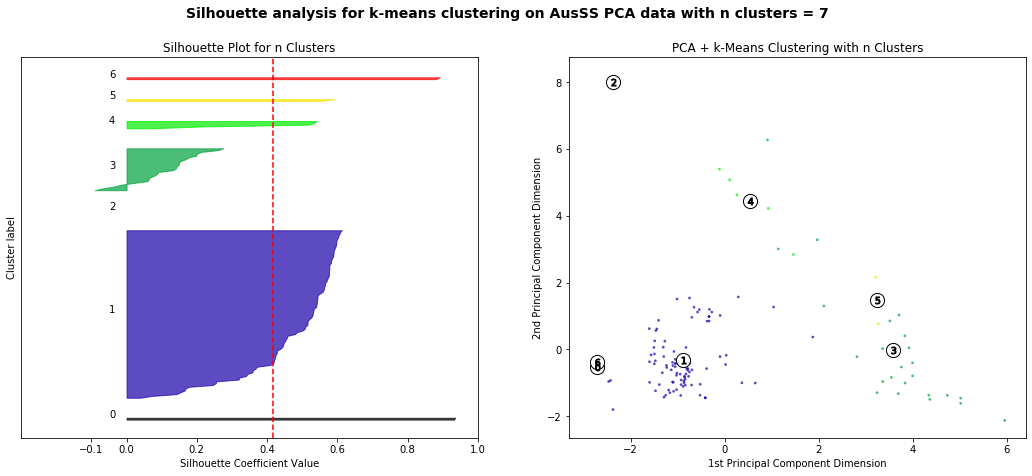

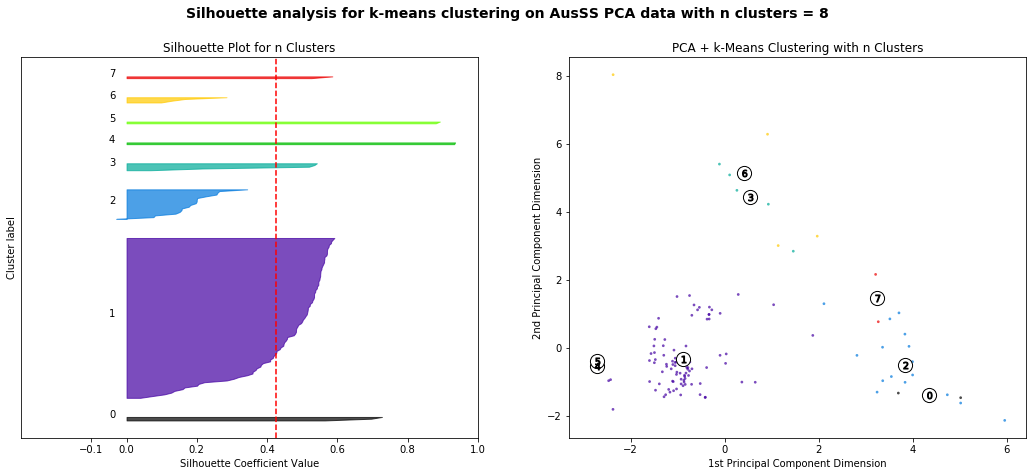

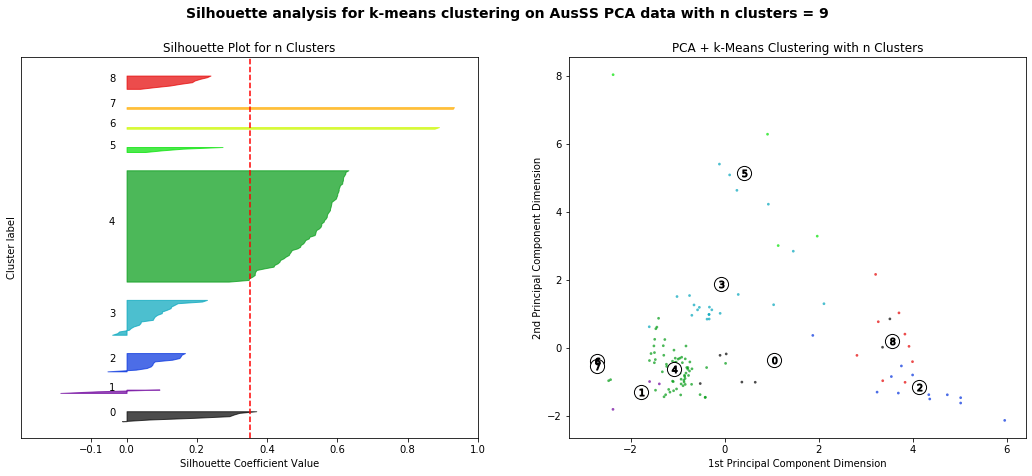

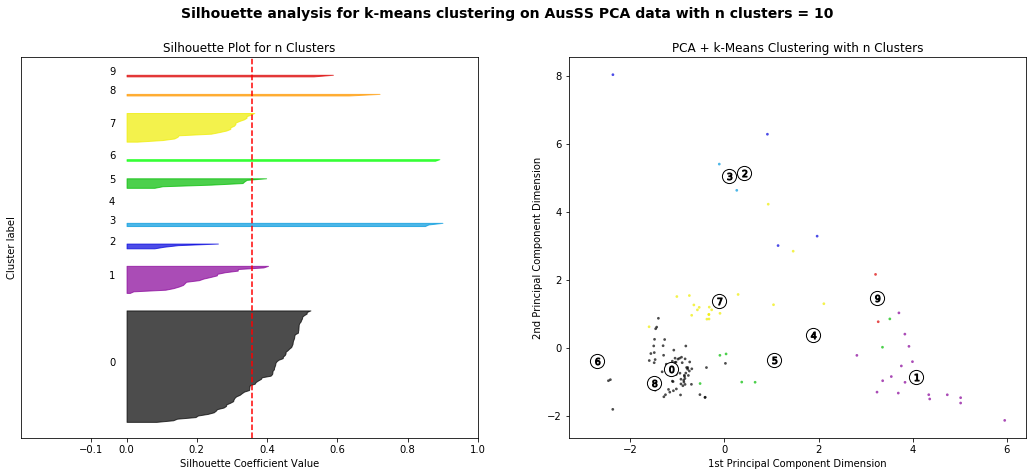

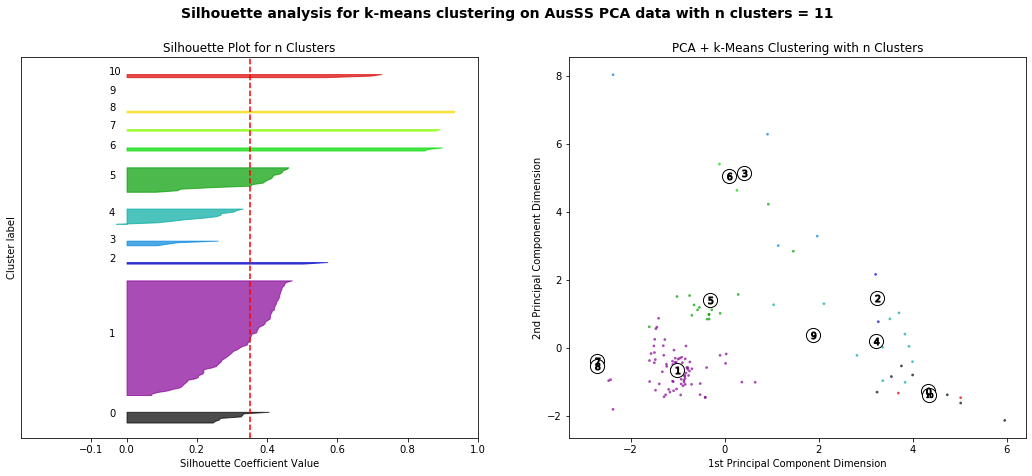

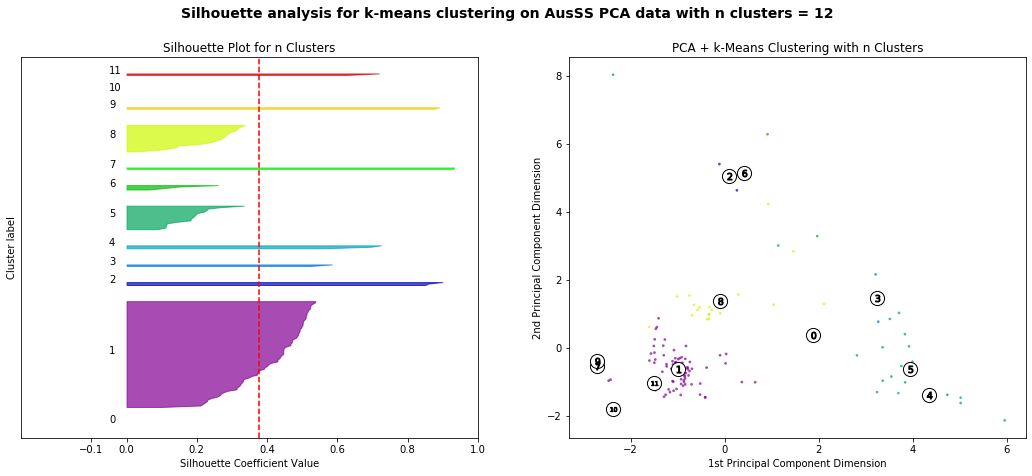

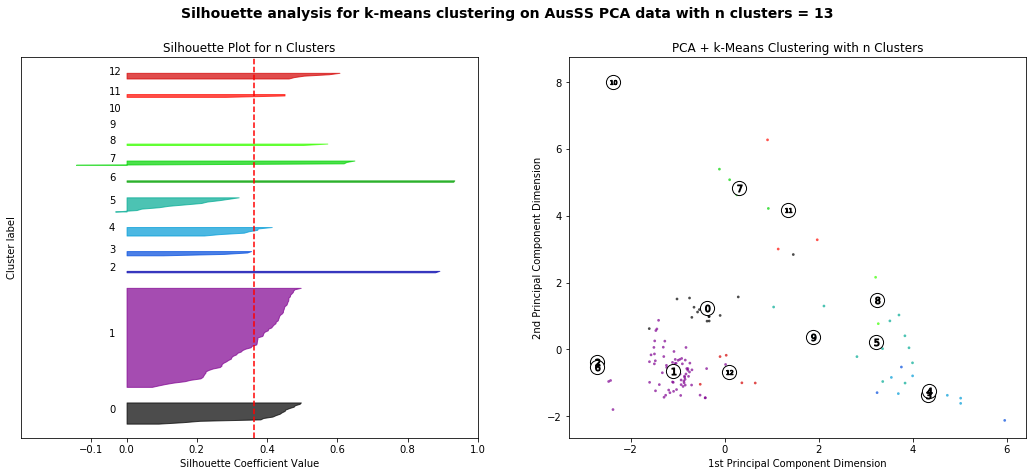

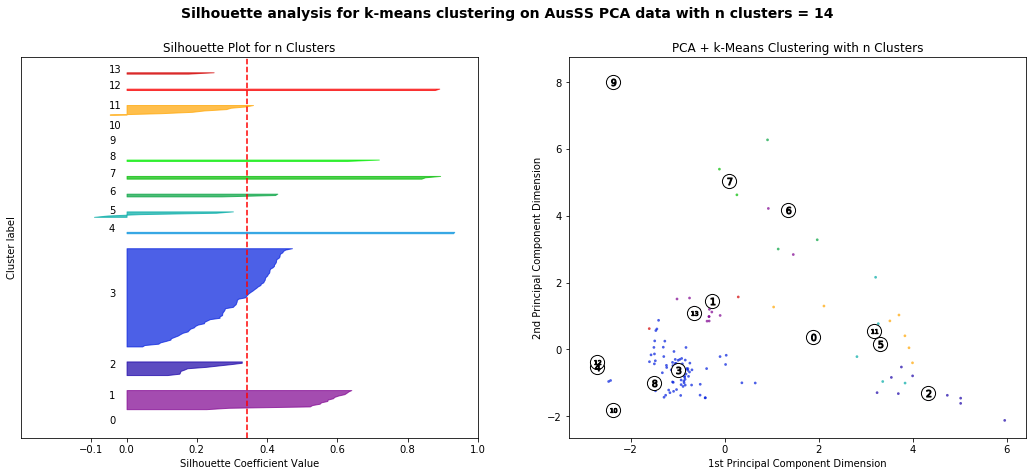

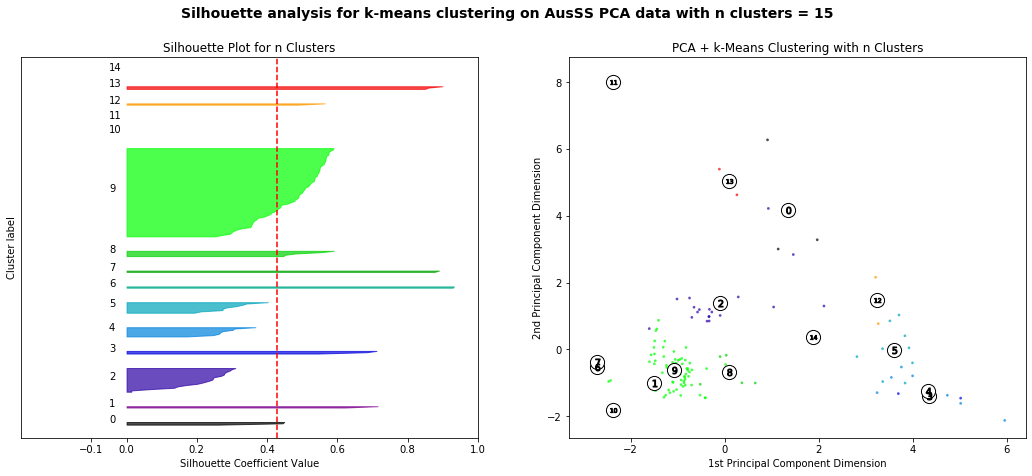

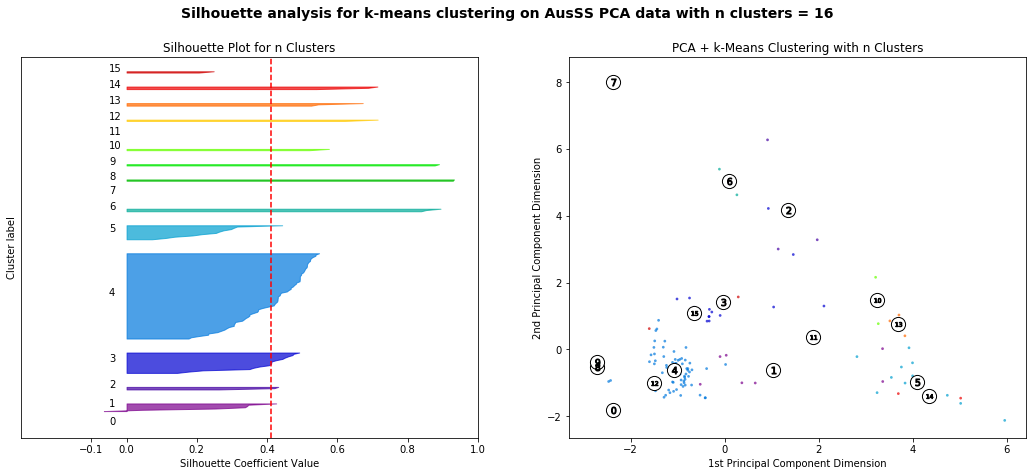

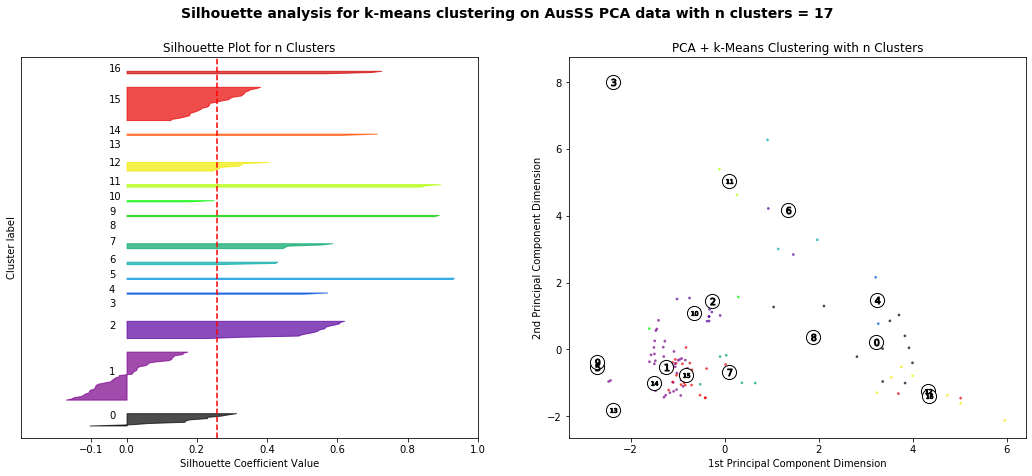

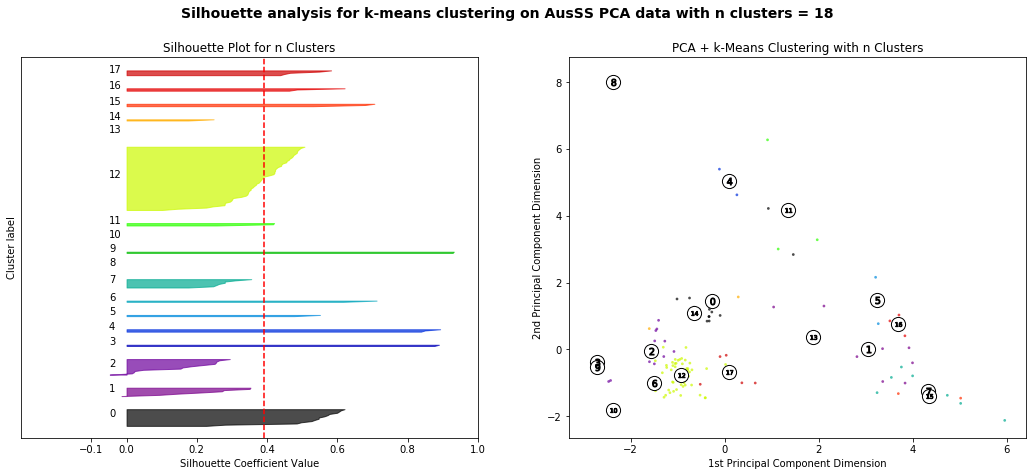

In [25]:
# From: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

print(__doc__)

# Set data
X = data_PCA

# Set numbers of clusters to test
range_n_clusters = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.3, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for n Clusters")
    ax1.set_xlabel("Silhouette Coefficient Value")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("PCA + k-Means Clustering with n Clusters")
    ax2.set_xlabel("1st Principal Component Dimension")
    ax2.set_ylabel("2nd Principal Component Dimension")

    plt.suptitle(("Silhouette analysis for k-means clustering on AusSS PCA data "
                  "with n clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig('PCA_kMeans_silhouette_AusSS_' + str(n_clusters) +'.png', format='PNG')
plt.show()

In [26]:
# Determine number of clusters from above Elbow Method plot, silhouette score
num_clusters = 15

In [71]:
# Run k-means clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000, n_init=100, random_state=0)
pred_y = kmeans.fit_predict(df_PCA)

In [59]:
# Add kMeans labels to dataset
df_tensile_outliers_ID['kMeans_label'] = kmeans.labels_

following code adjusted from:
https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster

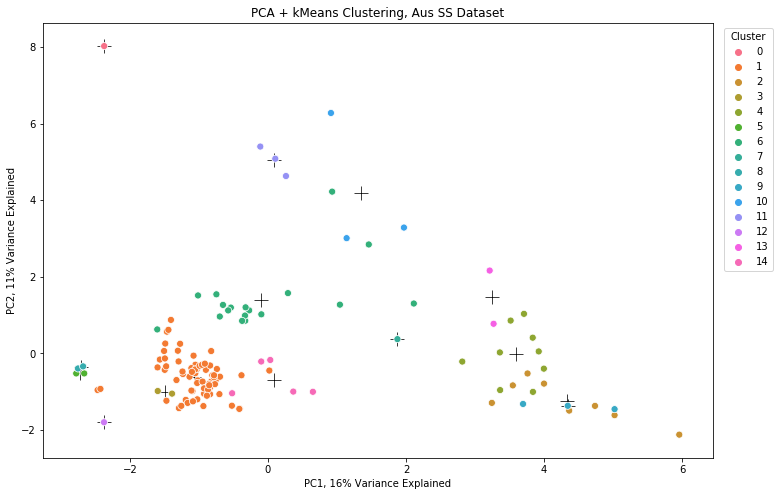

In [34]:
# plot
plt.figure(figsize = (12,8))
sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', color='black', s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('PCA + kMeans Clustering, Aus SS Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

### Summarize k-Means cluster attributes

In [32]:
# filter out clusters with 2 or less points (get average values)
df_tensile_outliers_ID_kMgr1 = df_tensile_outliers_ID.groupby('kMeans_label').filter(lambda x : len(x)>2)

In [33]:
df_tensile_outliers_ID_kMgr1.groupby(df_tensile_outliers_ID_kMgr1.kMeans_label).mean()

,Fe,C,Cr,Mn,Si,Ni,Co,Mo,W,Nb,Al,P,Cu,Ta,V,B,N,O,S,Y,Homo,Normal,Temper1,AGS No.
kMeans_label,,,,,,,,,,,,,,,,,,,,,,,,
1,67.566559,0.061368,17.778956,1.403574,0.599015,11.282853,6.476207,0.985272,0.201193,0.209309,0.075366,0.023160,0.160584,0.059978,0.025931,0.001026,0.025799,0.003388,0.010953,0.062186,0.0,1099.261069,1007.450980,5.018312
2,23.710000,0.017812,16.166250,19.006250,0.170669,20.442500,20.590000,0.427235,0.081447,0.126530,0.095550,0.008389,0.070093,0.024522,0.015443,0.001157,0.005712,0.001413,0.005025,0.045405,1.0,991.479839,1023.333333,4.760274
4,18.689100,0.016100,19.168889,0.123333,0.069087,39.322222,19.311111,3.379922,0.031244,0.034602,0.065274,0.003189,0.022731,0.007636,0.011613,0.001157,0.002789,0.003122,0.004089,0.062186,1.0,1031.426523,1023.333333,4.760274
6,35.083774,0.064474,19.538947,0.912632,0.420000,42.771463,1.029814,0.125805,0.201193,0.263020,0.340919,0.010895,0.119873,0.060724,0.024514,0.001179,0.042595,0.003388,0.006474,0.062186,0.0,1111.058857,1011.578947,3.484211
9,28.746667,0.021333,18.693333,16.256667,0.010000,18.380000,17.763333,0.010000,0.015133,0.123000,0.011667,0.001000,0.004000,0.001000,0.010000,0.001157,0.001367,0.001067,0.000867,0.106933,1.0,882.000000,1023.333333,4.760274
10,48.522057,0.021567,14.246667,1.043333,0.106667,30.006667,0.013333,0.683333,0.390000,1.321667,2.993333,0.001000,0.183667,0.011000,0.036667,0.001157,0.000423,0.000553,0.001400,0.062186,1.0,1096.279570,1023.333333,4.760274
11,18.333333,0.066667,21.233333,0.443333,0.340000,48.272933,1.233333,8.900000,0.733333,0.252414,0.370000,0.010000,0.173583,0.060724,0.024514,0.004000,0.036800,0.003388,0.010000,0.062186,0.0,1150.000000,1023.333333,4.266667
14,68.639008,0.044560,18.670000,0.990000,0.298000,10.896000,1.542748,1.119294,0.126716,0.386600,0.012000,0.001000,0.013800,0.006600,0.010000,0.001157,0.000764,0.012178,0.001690,0.062186,1.0,1096.279570,1023.333333,4.760274


## Calculate z-score

In [60]:
# Calculate distance of each point from cluster center

dist_cluster = kmeans.transform(df_PCA)
dist_cluster_sq = kmeans.transform(df_PCA)**2

In [61]:
df_dist_cluster = pd.DataFrame(dist_cluster_sq.sum(axis=1).round(2), columns=['sqdist'])
df_dist_cluster['label'] = pd.DataFrame(pred_y)

In [36]:
# for each cluster, find the z values (# of st. dev away from cluster center)

# create a copy of the dataframe
df_dist_cluster2 = df_dist_cluster
# create a blank list for collecting dataframe subsets
df_zvalue = []

for label in np.unique(kmeans.labels_):
    # subset dataframe by label
    label_subset = df_dist_cluster2[df_dist_cluster2['label'] == label]
    # calculate zscore for each point
    label_subset['zval_stats'] = stats.zscore(label_subset['sqdist'])
    df_zvalue.append(label_subset)

# Concatenate list of dataframes into one dataframe
df_zvalue_whole = pd.concat(df_zvalue)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Set z-score threshold

In [38]:
# find points that are more than the z-score in number of standard deviation away from the mean
outlier_indices = df_zvalue_whole.index[df_zvalue_whole['zval_stats'] >= 1]

In [39]:
outlier_indices

Int64Index([46, 48, 109, 119, 120, 100, 121, 104, 106, 28, 12, 14, 72, 127, 94,
            80, 85, 76],
           dtype='int64')

In [40]:
# Indicate outliers in the dataset
df_tensile_outliers_ID['outlier_identified_zvalue'] = 0
df_tensile_outliers_ID.loc[outlier_indices, 'outlier_identified_zvalue'] = 1

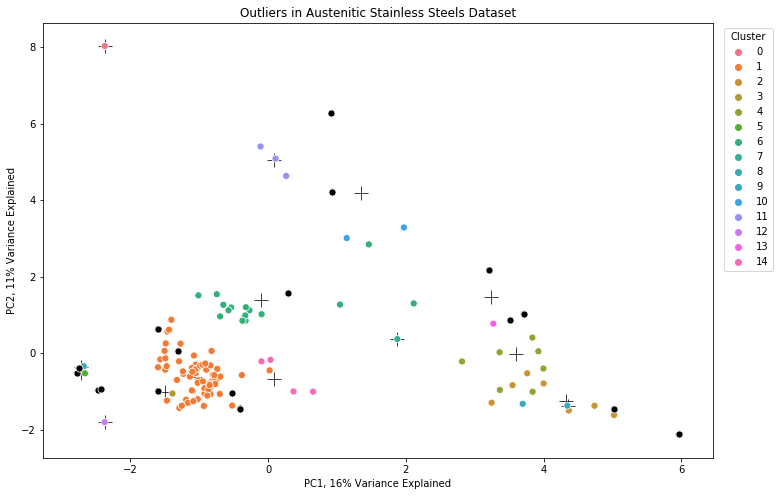

In [47]:
# replot, but highlight the outliers as given by z-value
plt.figure(figsize = (12,8))

sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', color='black', s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50);
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices, 0], df_PCA.iloc[outlier_indices, 1], color='black', s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('Outliers in Austenitic Stainless Steels Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

### Find points where only 1 or 2 data points per cluster, add as outliers in new column

In [41]:
Kmeans_smcl_all = df_tensile_outliers_ID['kMeans_label'].value_counts().reset_index(name = "count")
Kmeans_smcl_all

,index,count
0,1,68
1,6,19
2,4,9
3,2,8
4,14,5
5,11,3
6,10,3
7,9,3
8,13,2
9,8,2


In [42]:
# Find kMeans clusters where only  1 or 2 data points per cluster

Kmeans_smcl = df_tensile_outliers_ID['kMeans_label'].value_counts().reset_index(name = "count").query("count <= 2")["index"]
Kmeans_smcl

8     13
9      8
10     5
11     3
12    12
13     7
14     0
Name: index, dtype: int64

In [43]:
# make a list of kMeans clusters with low data points
Kmeans_smcl = Kmeans_smcl.tolist()

In [44]:
# find rows of df_tensile_outliers_ID where kMeans_label is in the list above: Kmeans_smcl
outlier_indices_cl = df_tensile_outliers_ID.index[df_tensile_outliers_ID['kMeans_label'].isin(Kmeans_smcl)]

In [45]:
# Indicate outliers in the dataset
df_tensile_outliers_ID['outlier_identified_zvalue_cl'] = 0
df_tensile_outliers_ID.loc[outlier_indices, 'outlier_identified_zvalue_cl'] = 1
df_tensile_outliers_ID.loc[outlier_indices_cl, 'outlier_identified_zvalue_cl'] = 1

In [46]:
Kmeans_all = df_tensile_outliers_ID[df_tensile_outliers_ID['outlier_identified_zvalue_cl'] == 1]['kMeans_label'].value_counts()
Kmeans_all

1     5
6     3
13    2
8     2
5     2
4     2
3     2
14    1
12    1
10    1
9     1
7     1
2     1
0     1
Name: kMeans_label, dtype: int64

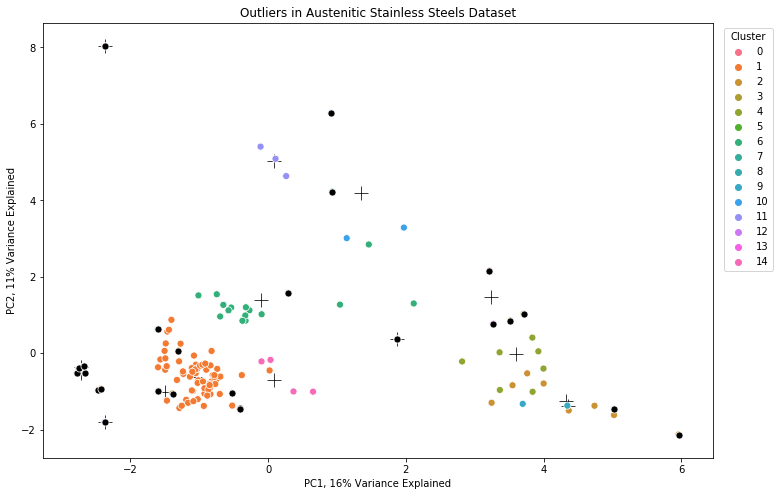

In [48]:
# replot, but highlight the outliers as given by z-value AND small cluster values
plt.figure(figsize = (12,8))

sns.scatterplot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='+', color='black', s=200);
sns.scatterplot(df_PCA[0], df_PCA[1], hue=pred_y, 
                palette=sns.color_palette("husl", n_colors=num_clusters), s = 50);
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices, 0], df_PCA.iloc[outlier_indices, 1], color='black', s = 50)
# highlight the furthest point in black
sns.scatterplot(df_PCA.iloc[outlier_indices_cl, 0], df_PCA.iloc[outlier_indices_cl, 1], color='black', s = 50)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1, title = "Cluster")
plt.title('Outliers in Austenitic Stainless Steels Dataset')
# Set x-axis label
plt.xlabel('PC1, %d' %(pca_model.explained_variance_ratio_[0]*100).round(0) + '% Variance Explained')
# Set y-axis label
plt.ylabel('PC2, %d' %(pca_model.explained_variance_ratio_[1]*100).round(0) + '% Variance Explained')
plt.show();

## Plot outliers vs. original attributes

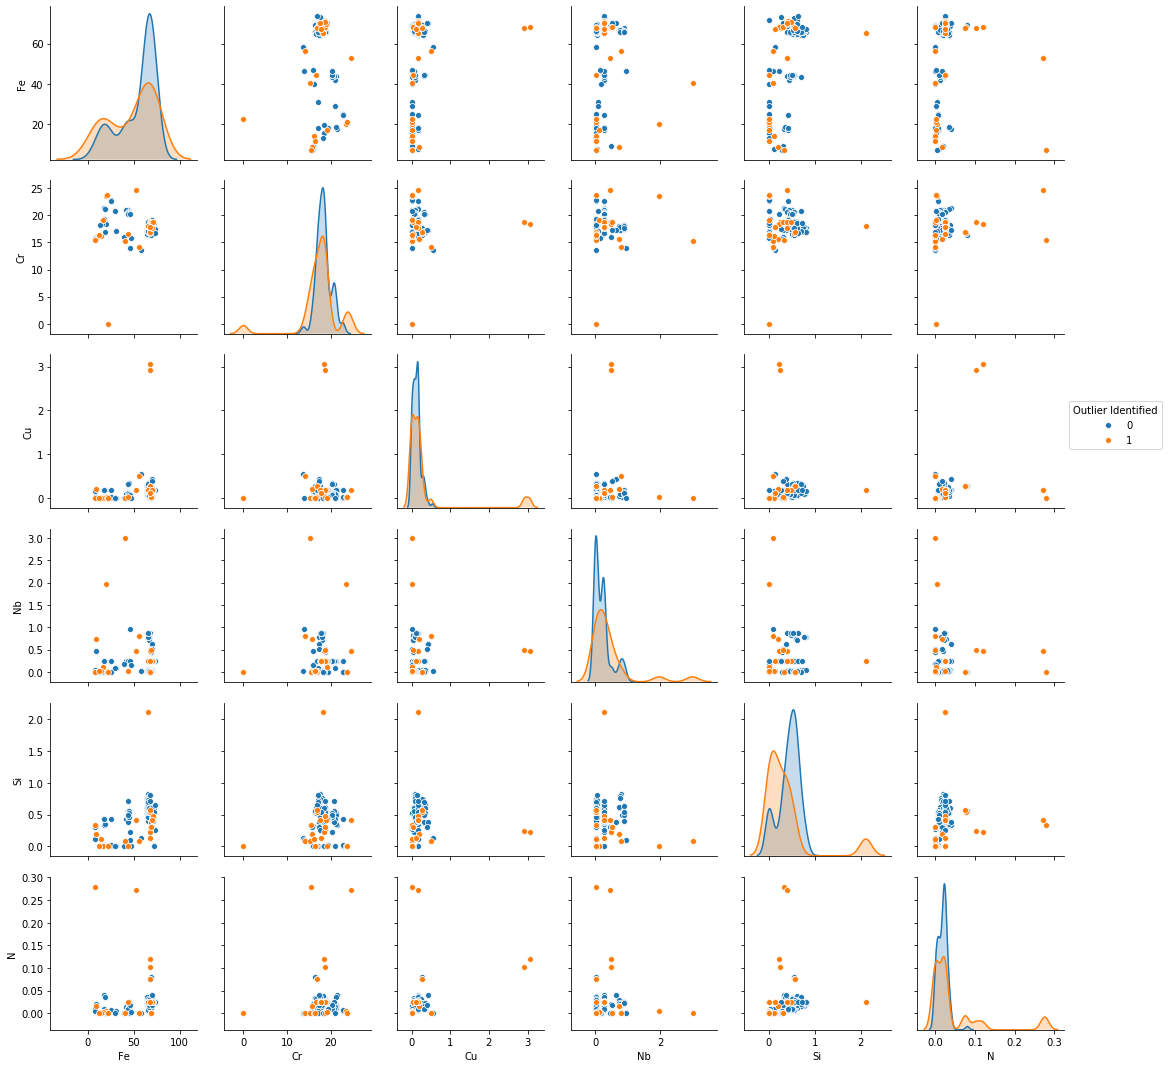

In [50]:
g = sns.pairplot(df_tensile_outliers_ID, vars = df_tensile_outliers_ID[['Fe', 'Cr', 'Cu', 'Nb', 'Si', 'N']], hue = "outlier_identified_zvalue_cl")
g._legend.remove()
plt.legend(bbox_to_anchor=(1, 3), loc='upper left', ncol=1, title = 'Outlier Identified')
plt.show();